In [15]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
from math import pi
from matplotlib.lines import Line2D

In [2]:
def read_json_lines(filename):
    data = []
    try:
        with open(filename, "r", encoding="utf-8") as file:
            for line_num, line in enumerate(file, 1):
                line = line.strip()
                if not line:  # пропускаем пустые строки
                    continue
                try:
                    json_obj = json.loads(line)
                    data.append(json_obj)
                except json.JSONDecodeError as e:
                    print(f"Ошибка парсинга JSON на строке {line_num}: {e}")
                    print(f"Содержимое строки: {line}")
    except FileNotFoundError:
        print(f"Файл {filename} не найден.")
    except Exception as e:
        print(f"Произошла ошибка при чтении файла: {e}")
    return data

In [3]:
meteo = pd.DataFrame(
    columns=[
        "id_s",
        "batt",
        "rssi",
        "datetime",
        "temp_air",
        "hum_air",
        "pres_hpa",
        "press_mm",
        "wind_dir",
        "wind_speed",
        "wind_gust",
        "uv_power",
        "uv_index",
        "ilum",
        "rain",
        "hum_soil",
        "temp_soil",
    ]
)
ugv = pd.DataFrame(
    columns=[
        "id_s",
        "batt",
        "rssi",
        "datetime",
        "t1",
        "t2",
        "t3",
        "t4",
        "t5",
        "h1",
        "h2",
        "h3",
        "h4",
        "h5",
    ]
)

In [8]:
param_dict = {
    "temp_air": "Температура воздуха, °С",
    "hum_air": "Влажность воздуха, %",
    "pres_hpa": "Давление, гПа",
    "press_mm": "Давление, мм.рт.ст",
    "wind_dir": "Направление ветра",
    "wind_speed": "Скорость ветра, м/с",
    "wind_gust": "Порыв ветра, м/с",
    "uv_power": "УФ интенсивность, мкВт/см2",
    "uv_index": "УФ индекс",
    "ilum": "Освещенность, люкс",
    "rain": "Осадки, мм",
    "hum_soil": "Влажность почвы, %",
    "temp_soil": "Температура почвы, °С",
    "t1": "Температура почвы, глубина 10см, °С",
    "t2": "Температура почвы, глубина 20см, °С",
    "t3": "Температура почвы, глубина 30см, °С",
    "t4": "Температура почвы, глубина 40см, °С",
    "t5": "Температура почвы, глубина 50см, °С",
    "h1": "Влажность почвы, глубина 10см, %",
    "h2": "Влажность почвы, глубина 20см, %",
    "h3": "Влажность почвы, глубина 30см, %",
    "h4": "Влажность почвы, глубина 40см, %",
    "h5": "Влажность почвы, глубина 50см, %",
}

sens_dict = {
    "1": "В1 1386 центр",
    "5": "М5 1756 верх",
    "7": "М7 1756 низ",
    "10": "М10 1386 центр",
    "11": "В11 1756 центр",
}

In [16]:
meteo = pd.read_excel("meteo.xlsx")
ugv = pd.read_excel("ugv.xlsx")
meteo['id_s']=np.array(meteo['id_s'], dtype=str)
ugv['id_s']=np.array(ugv['id_s'], dtype=str)

print(len(meteo), len(ugv))

4476 2716


In [5]:
data = read_json_lines("log full.json")
print(len(data))


def restore_series(observed):
    restored = []
    for i, y in enumerate(observed):
        if i == 0:
            if y + 25.5 <= 50:
                restored.append(y)  # пока по умолчанию
            else:
                restored.append(y)
        else:
            prev = restored[i - 1]
            x1 = y
            x2 = y + 25.5
            candidates = []
            if -10 <= x1 <= 50:
                candidates.append(x1)
            if -10 <= x2 <= 50:
                candidates.append(x2)
            best = min(candidates, key=lambda x: abs(x - prev))
            restored.append(best)
    return restored


if len(meteo) > 1:
    last_time = max([meteo["datetime"].max(), ugv["datetime"].max()])
else:
    last_time = pd.to_datetime("00:00:00 01.01.2025", format="%H:%M:%S %d.%m.%Y")
for i in range(len(data)):
    ct = pd.to_datetime(
        list(data[i]["sens"].values())[3] + ".2025", format="%H:%M:%S %d.%m.%Y"
    )
    if ct > last_time:
        if data[i]["sens"]["id_s"] == "1" or data[i]["sens"]["id_s"] == "11":
            if "port_1" in data[i]:
                t = []
                h = []
                for j in range(5):
                    t.append(data[i]["port_1"][j]["temperature"])
                    h.append(data[i]["port_1"][j]["moisture"])
                sens = list(data[i]["sens"].values())
                li = sens[0:3]
                li.append(pd.to_datetime(sens[3] + ".2025", format="%H:%M:%S %d.%m.%Y"))
                li.extend(t)
                li.extend(h)
                ugv.loc[len(ugv)] = li
        if (
            data[i]["sens"]["id_s"] == "5"
            or data[i]["sens"]["id_s"] == "7"
            or data[i]["sens"]["id_s"] == "10"
        ):
            if "meteo" in data[i] and "soil" in data[i]:
                sens = list(data[i]["sens"].values())
                li = sens[0:3]
                li.append(pd.to_datetime(sens[3] + ".2025", format="%H:%M:%S %d.%m.%Y"))
                li.extend(data[i]["meteo"].values())
                li.extend(data[i]["soil"].values())
                meteo.loc[len(meteo)] = li

for q in ["1", "11"]:
    ind = ugv[ugv["id_s"] == q].index
    for p in ["t1", "t2", "t3", "t4", "t5"]:
        temp = restore_series(ugv[ugv["id_s"] == q][p].to_numpy())
        ser = ugv[ugv["id_s"] != q][p]
        ugv[p] = ser.combine_first(pd.Series(temp, index=ind))
ugv.to_feather("ugv.feather")
meteo.to_feather("meteo.feather")

5009


In [17]:
def plot_battary(time="all"):
    # ugv = pd.read_feather("ugv.feather")
    # meteo = pd.read_feather("meteo.feather")
    plt.figure(figsize=(12, 6), dpi=300)
    curent_time = max(ugv["datetime"].max(), meteo["datetime"].max())
    if time == "all":
        shift_time = min(ugv["datetime"].min(), meteo["datetime"].min())
    else:
        if time < 1:
            shift_time = (curent_time - pd.Timedelta(days=time)).replace(
                minute=0, second=0
            )
        else:
            shift_time = (curent_time - pd.Timedelta(days=time)).replace(
                hour=0, minute=0, second=0
            )
    for device_id in ugv["id_s"].unique():
        data = ugv[ugv["id_s"] == device_id]
        data_time_sort = data[
            (data["datetime"] <= curent_time) & (data["datetime"] >= shift_time)
        ]
        plt.plot(
            data_time_sort["datetime"],
            data_time_sort["batt"],
            label=sens_dict[device_id],
        )
    for device_id in meteo["id_s"].unique():
        data = meteo[meteo["id_s"] == device_id]
        data_time_sort = data[
            (data["datetime"] <= curent_time) & (data["datetime"] >= shift_time)
        ]
        plt.plot(
            data_time_sort["datetime"],
            data_time_sort["batt"],
            label=sens_dict[device_id],
        )

    plt.title("График заряда батарей")
    plt.ylabel("Батарея (%)")
    plt.grid(True, alpha=0.3)

    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%d.%m %H:%M"))
    plt.xticks(rotation=45)

    plt.legend(bbox_to_anchor=(1, 1), loc="upper left")
    plt.tight_layout()
    plt.show()
    plt.close()

In [ ]:
meteo

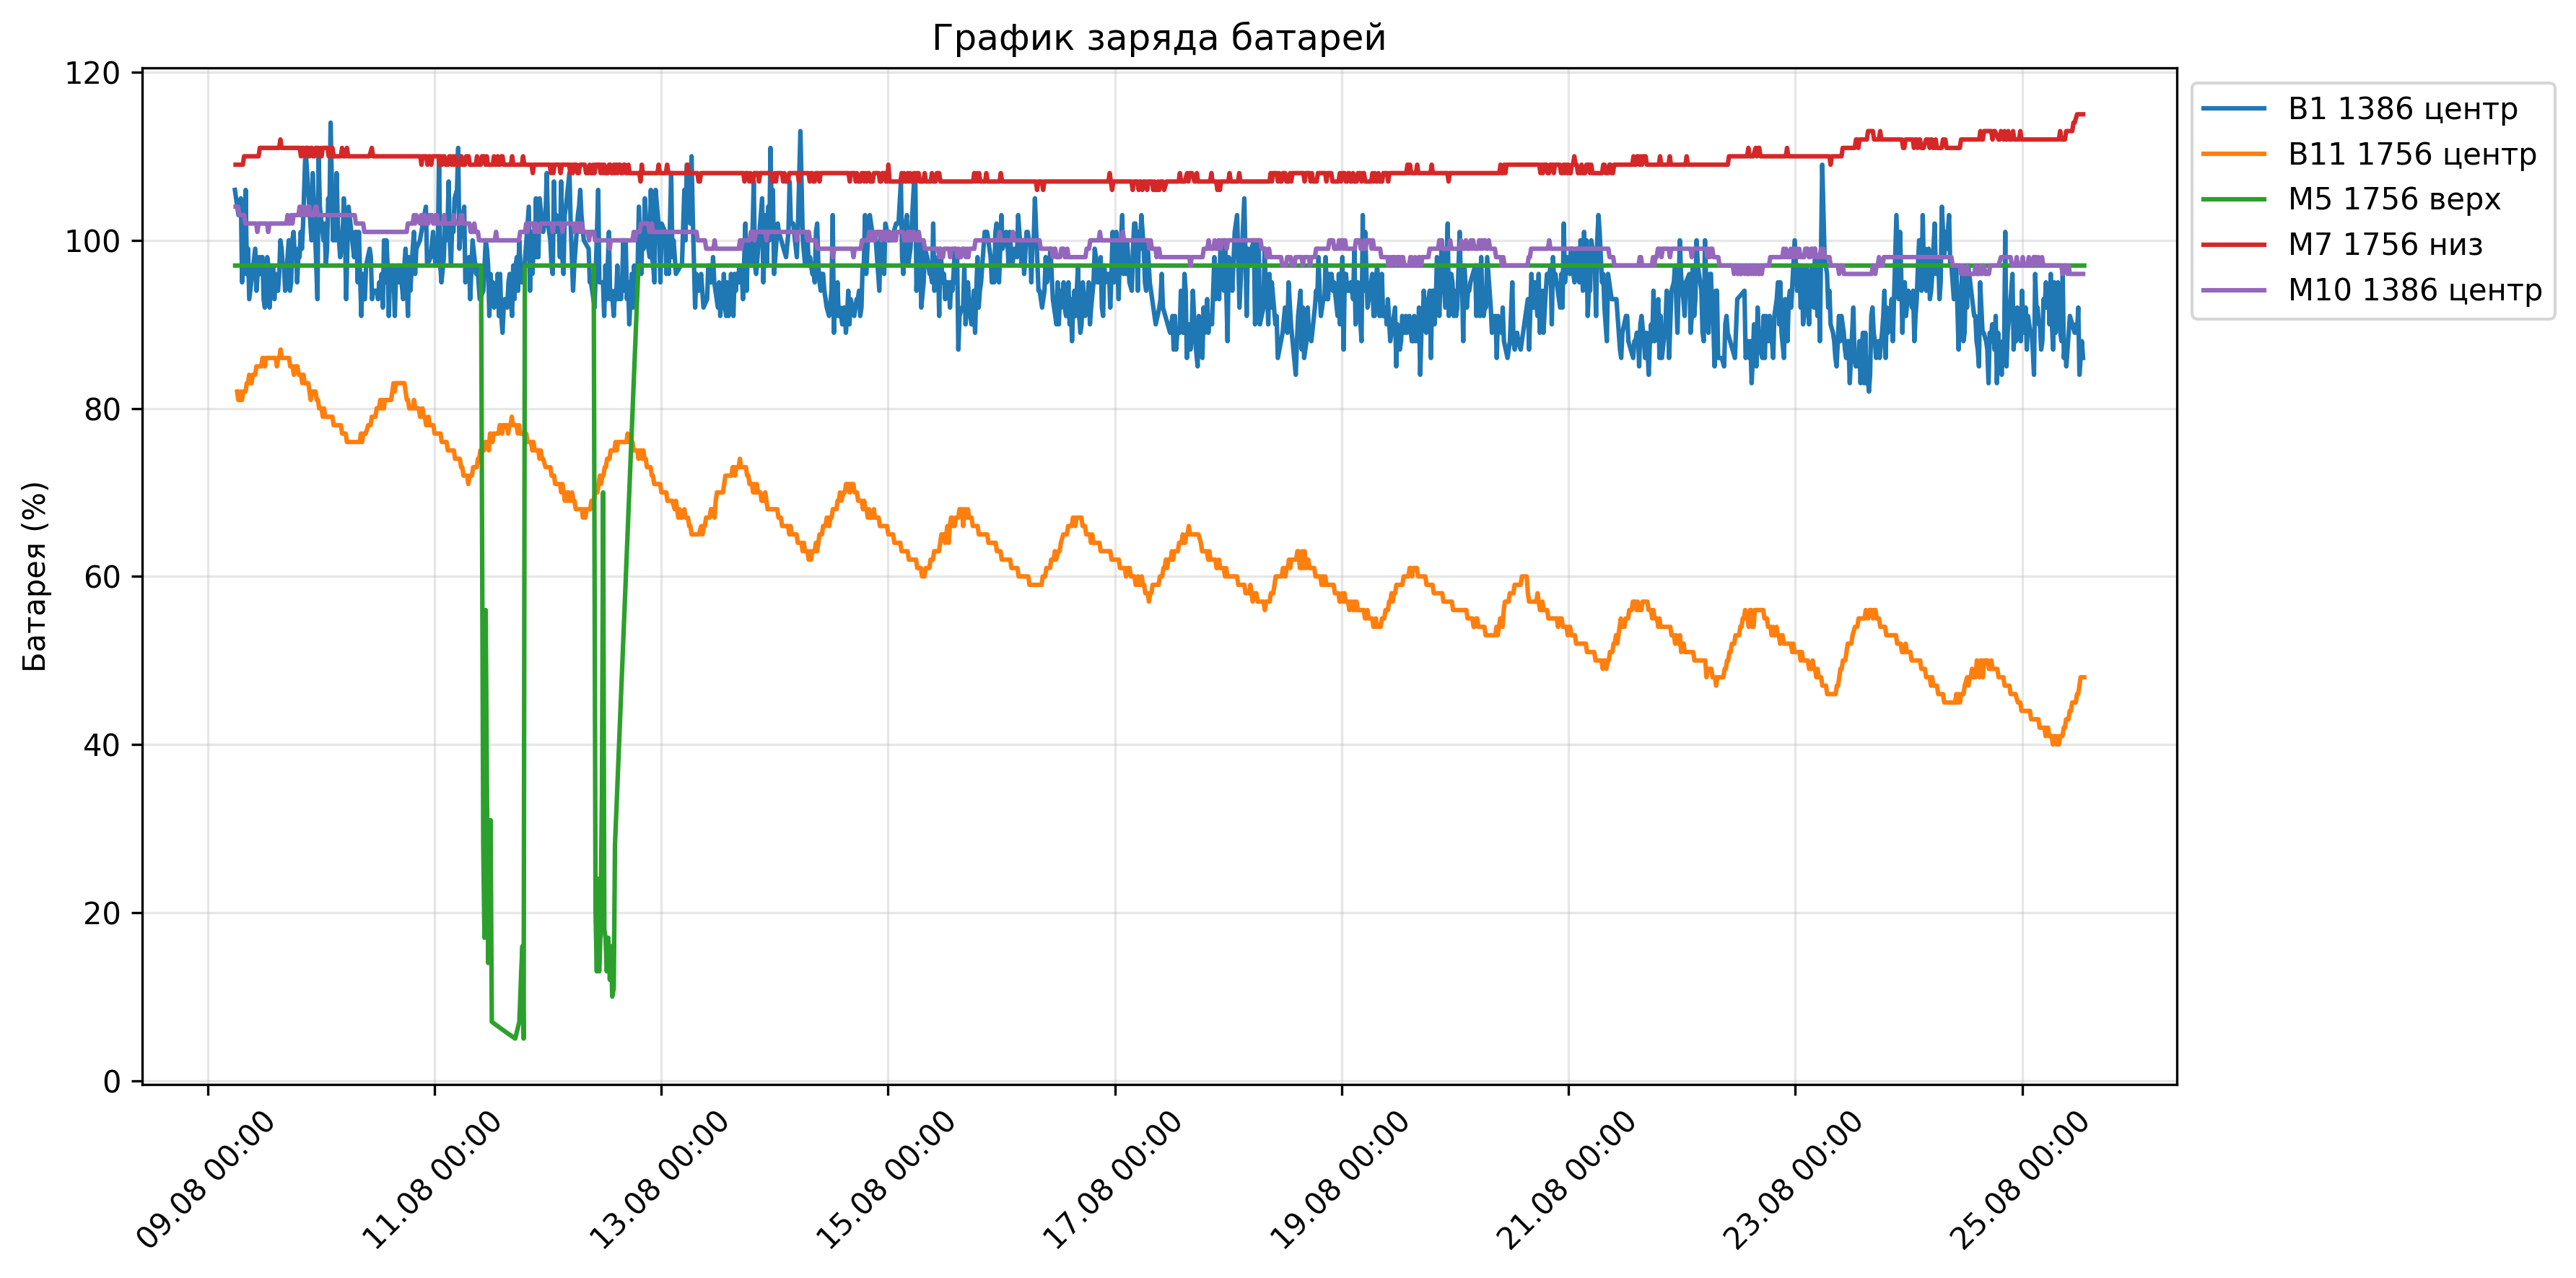

In [18]:

plot_battary()

In [106]:
def sys_info():
    ugv = pd.read_feather("ugv.feather")
    meteo = pd.read_feather("meteo.feather")
    #11
    answer = [['название','bat','rssi','time']]
    for device_id in meteo["id_s"].unique():
        last = meteo[meteo["id_s"] == device_id].tail(1)
        lt=str(last['datetime'].values[0])
        last_time = lt[11:19] + " " + lt[8:10] + "." + lt[5:7]
        answer.append([sens_dict[device_id],last['batt'].values[0],last['rssi'].values[0],last_time])
    for device_id in ugv["id_s"].unique():
        last = ugv[ugv["id_s"] == device_id].tail(1)
        lt=str(last['datetime'].values[0])
        last_time = lt[11:19] + " " + lt[8:10] + "." + lt[5:7]
        answer.append([sens_dict[device_id],last['batt'].values[0],last['rssi'].values[0],last_time])
    return(answer)

In [109]:
def format_table(data):
    # Определяем максимальную ширину для каждого столбца
    col_widths = [max(len(str(row[i])) for row in data) for i in range(len(data[0]))]
    
    # Формируем строки с выравниванием
    lines = []
    for row in data:
        line = "  ".join(str(cell).ljust(width) for cell, width in zip(row, col_widths))
        lines.append(line)
    
    return "\n".join(lines)

In [9]:
def plot_graph(df, parameter, time="all"):
    if df == "meteo":
        data = pd.read_feather("meteo.feather")
    if df == "ugv":
        data = pd.read_feather("ugv.feather")

    plt.figure(figsize=(12, 6))
    curent_time = data["datetime"].max()
    if time == "all":
        shift_time = data["datetime"].min()
    else:
        if time < 1:
            shift_time = (curent_time - pd.Timedelta(days=time)).replace(
                minute=0, second=0
            )
        else:
            shift_time = (curent_time - pd.Timedelta(days=time)).replace(
                hour=0, minute=0, second=0
            )
    data_time_sort = data[
        (data["datetime"] <= curent_time) & (data["datetime"] >= shift_time)
    ]
    for device_id in data_time_sort["id_s"].unique():
        data = data_time_sort[data_time_sort["id_s"] == device_id]
        plt.plot(data["datetime"], data[parameter], label=sens_dict[device_id])

    plt.title(f"График {param_dict[parameter]}")
    plt.grid(True, alpha=0.3)
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%d.%m %H:%M"))
    plt.xticks(rotation=60)
    plt.legend(bbox_to_anchor=(1, 1), loc="upper left")
    plt.tight_layout()
    plt.show()
    plt.savefig("pic.png")

    plt.close()

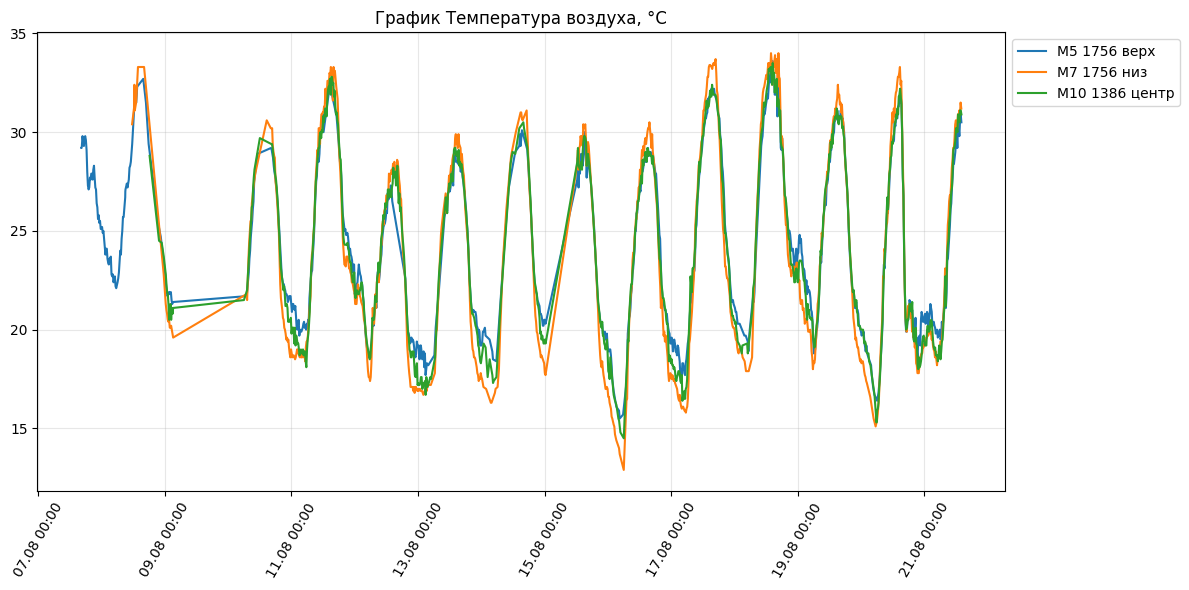

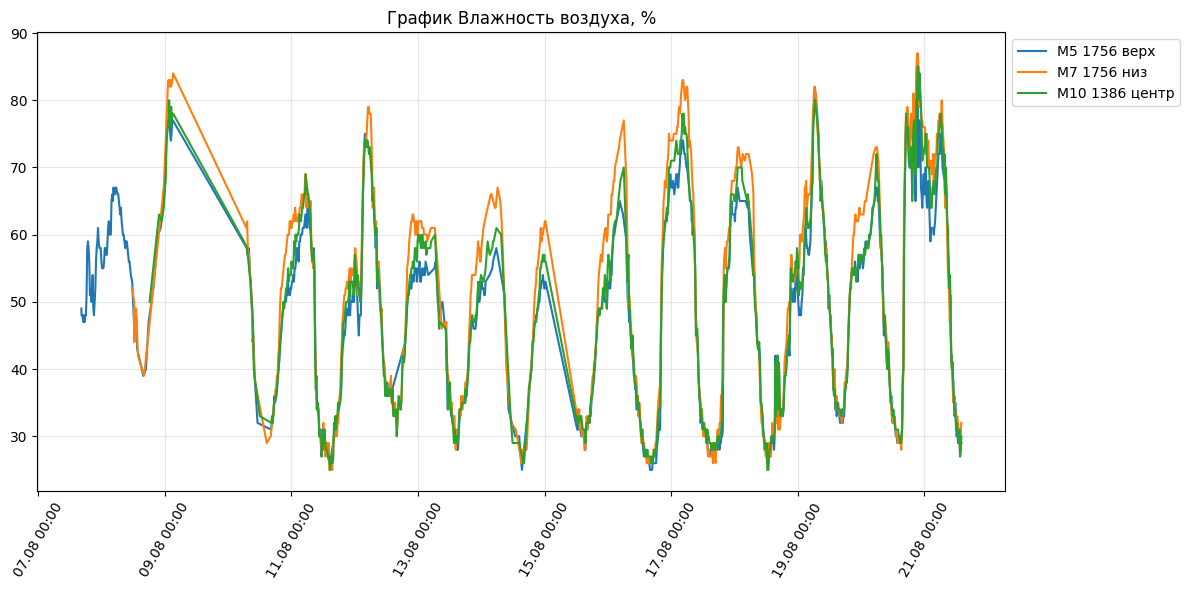

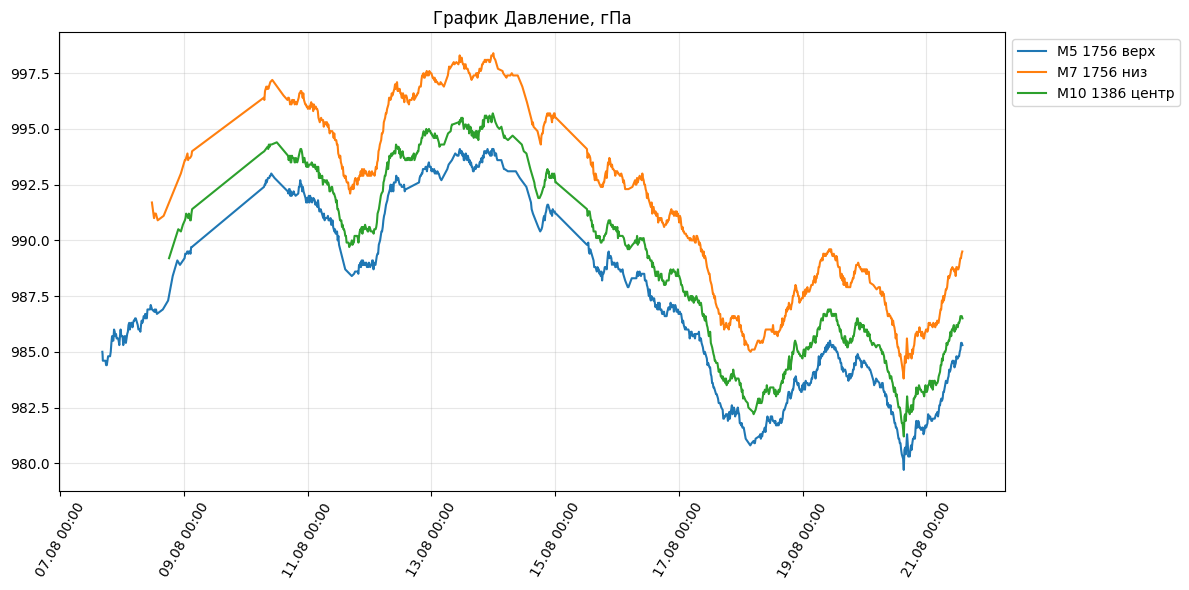

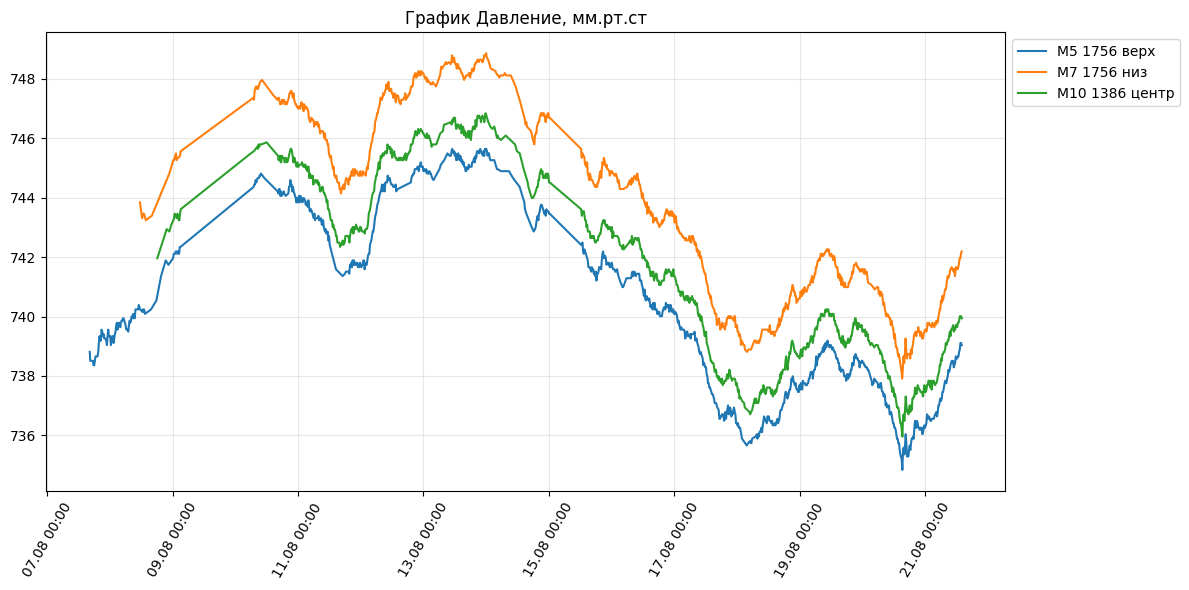

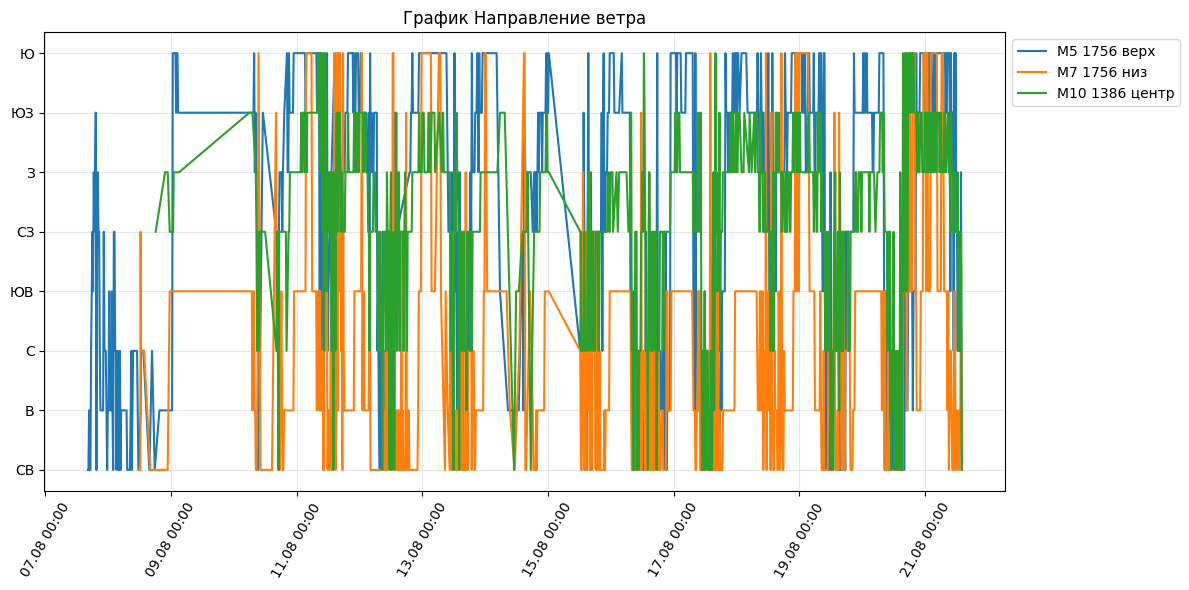

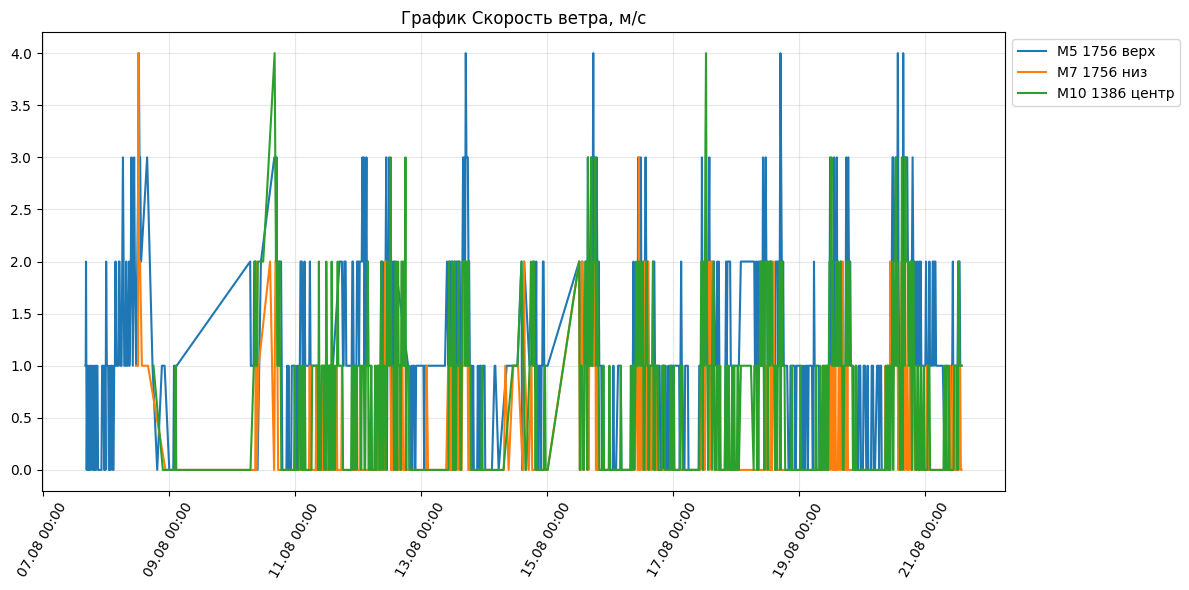

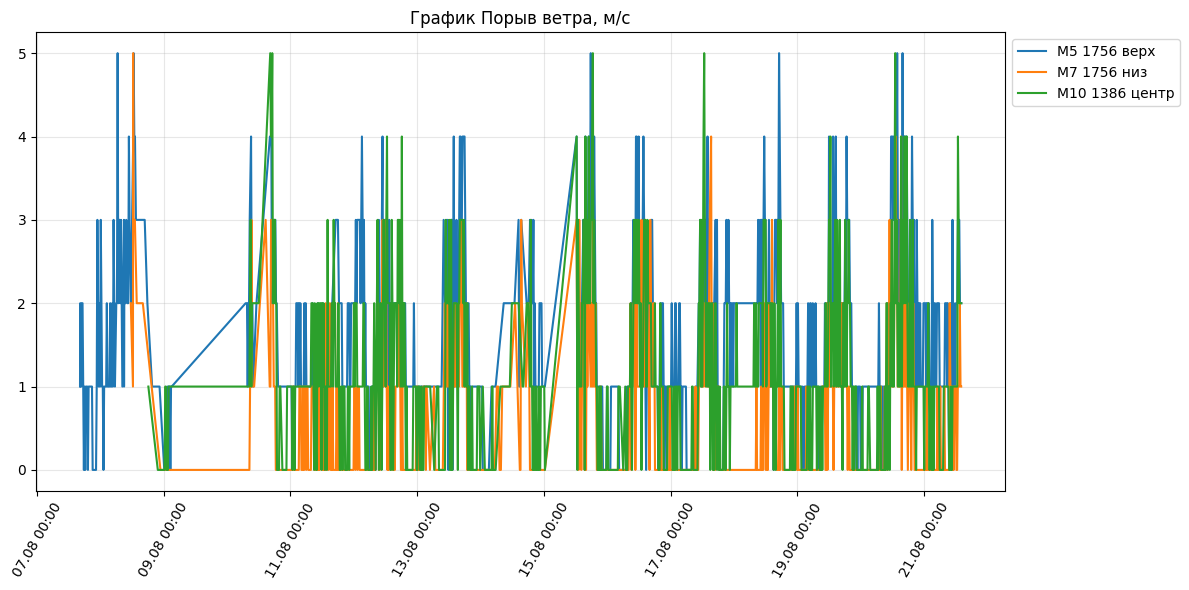

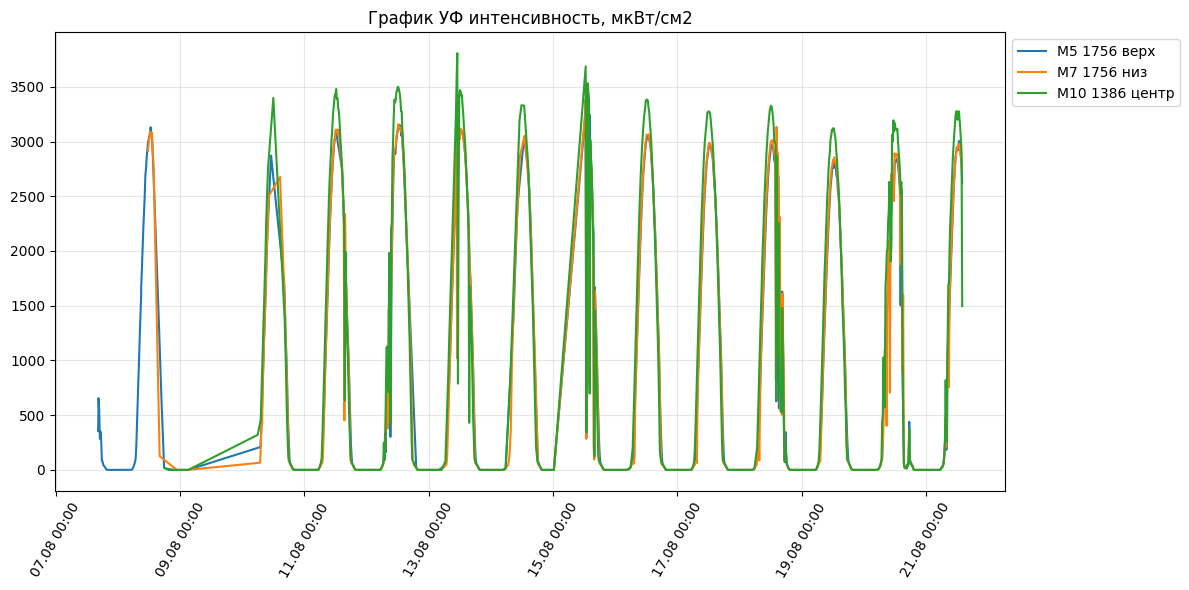

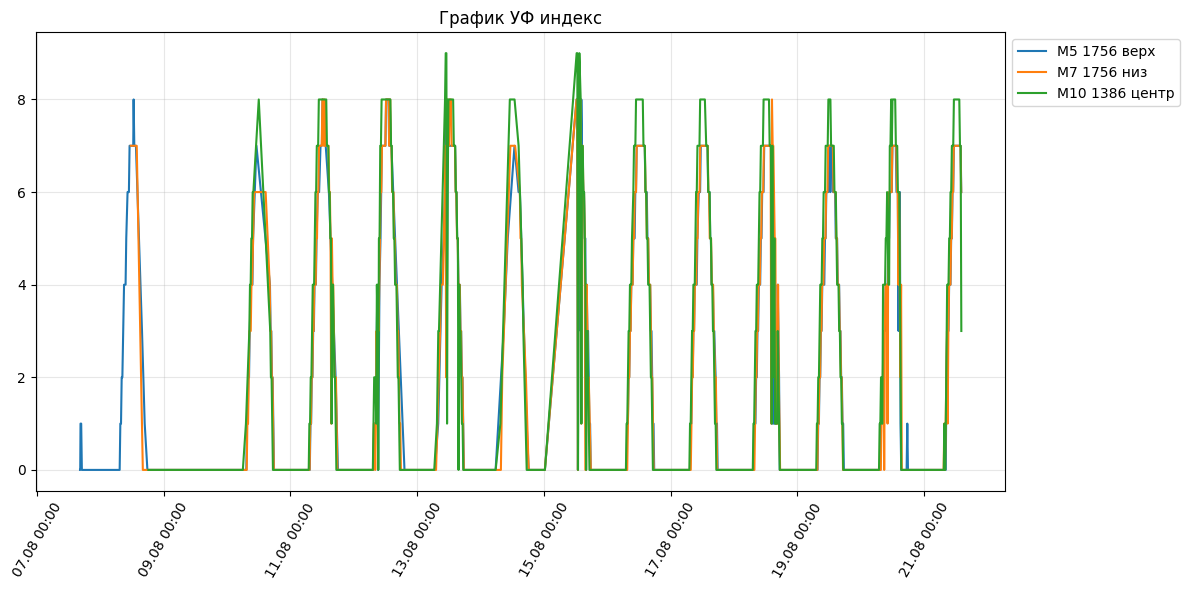

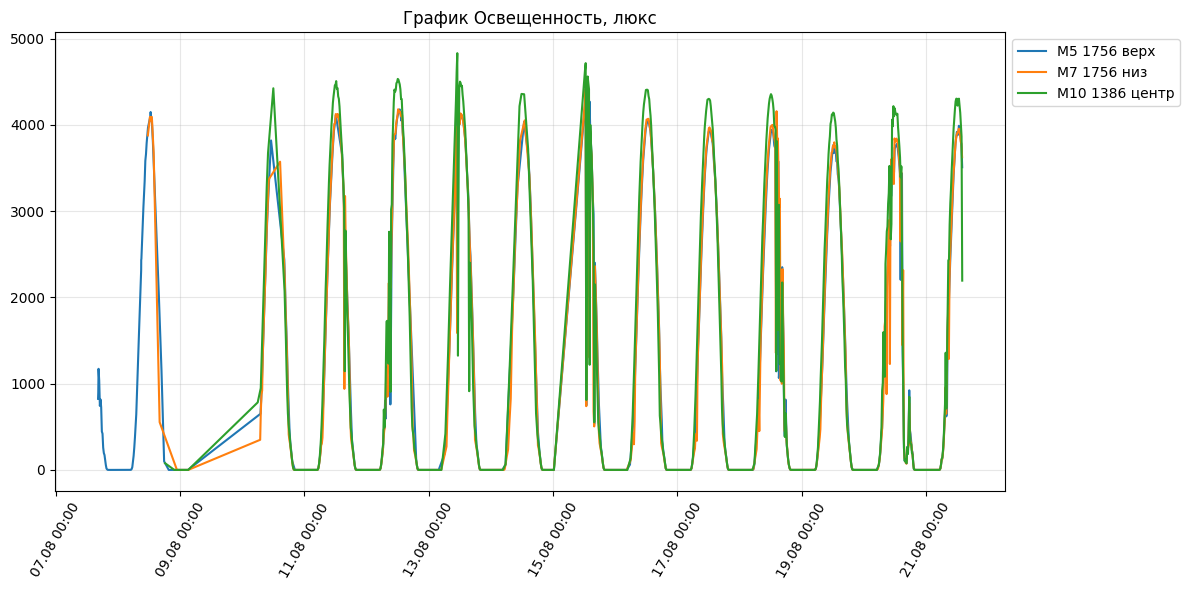

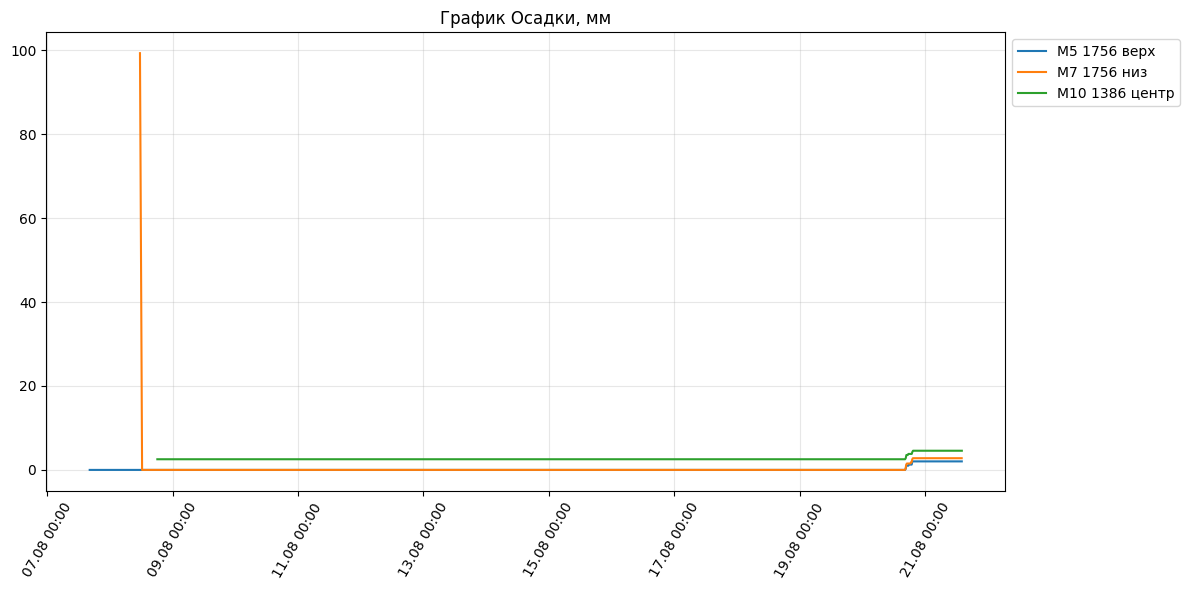

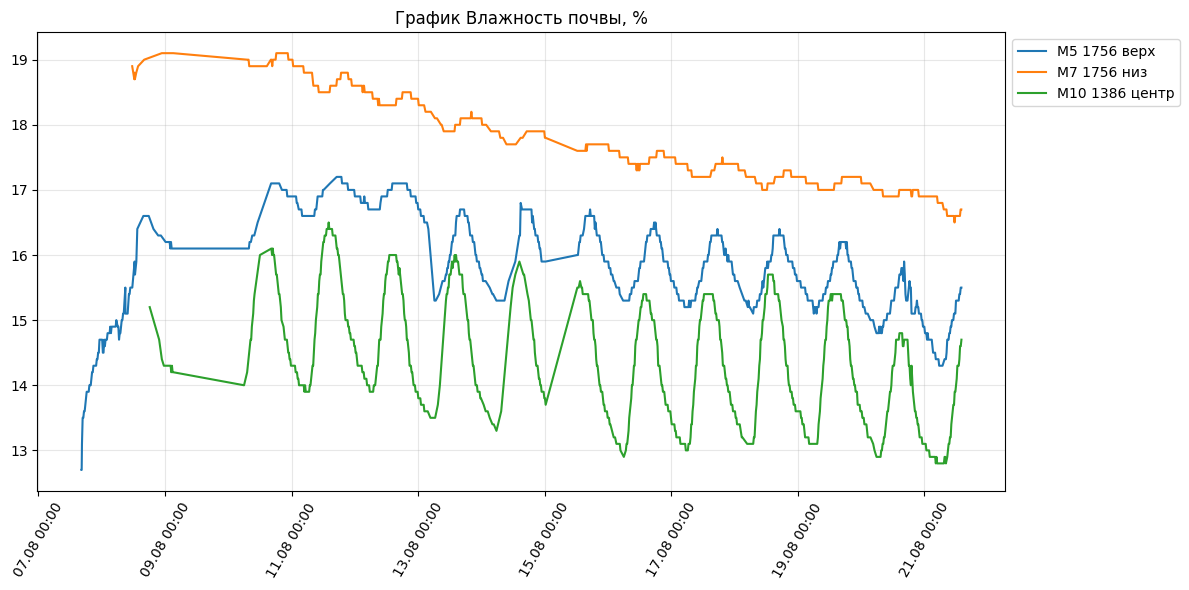

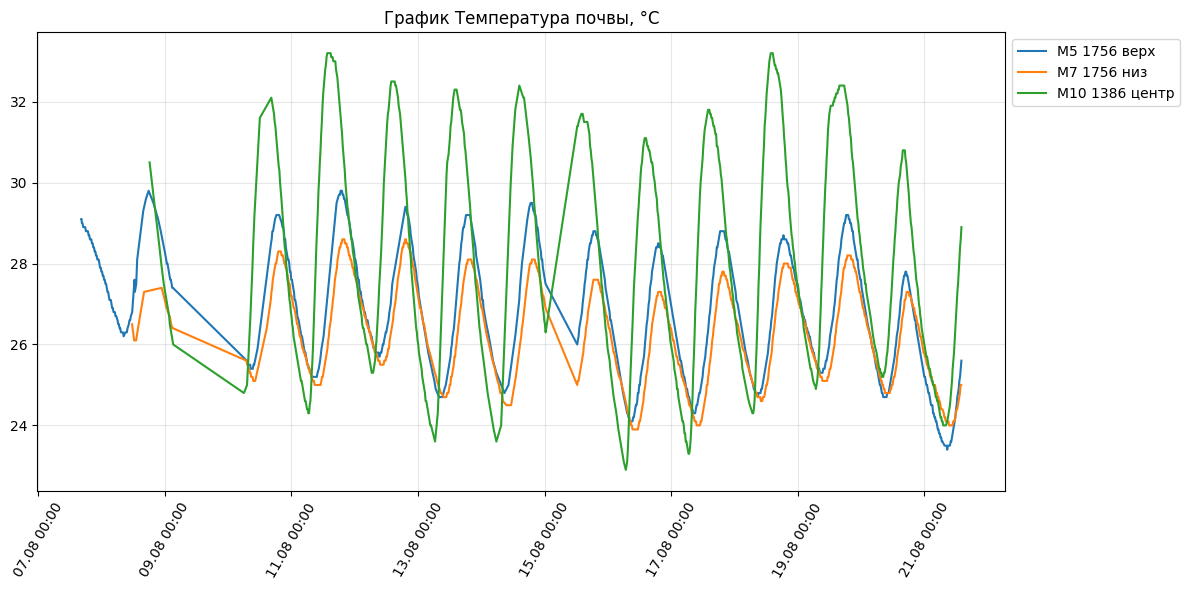

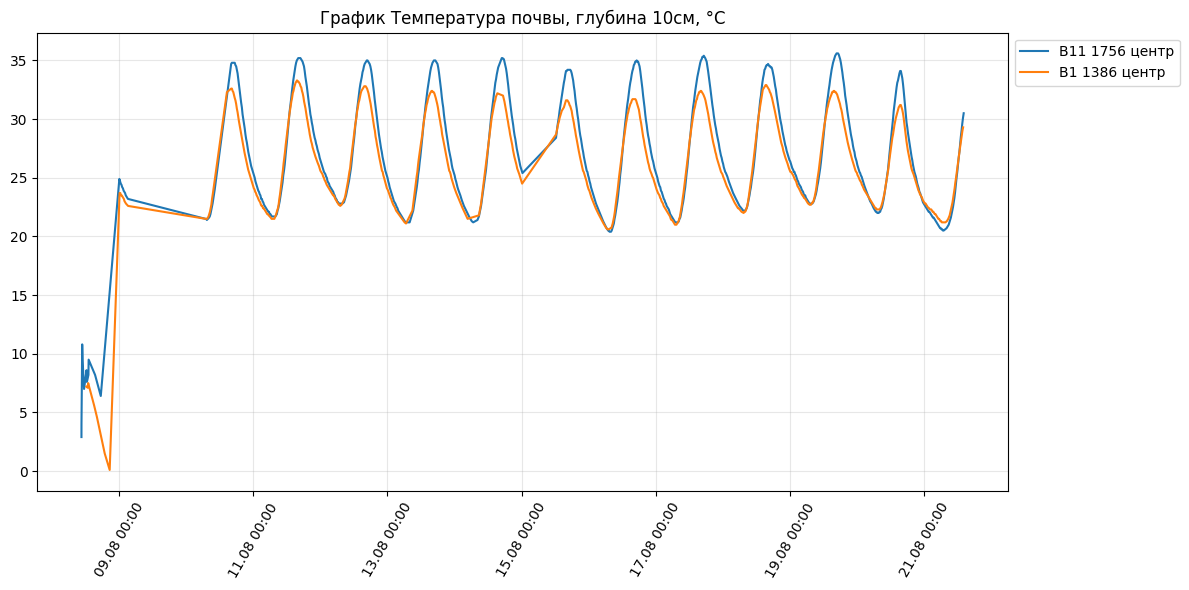

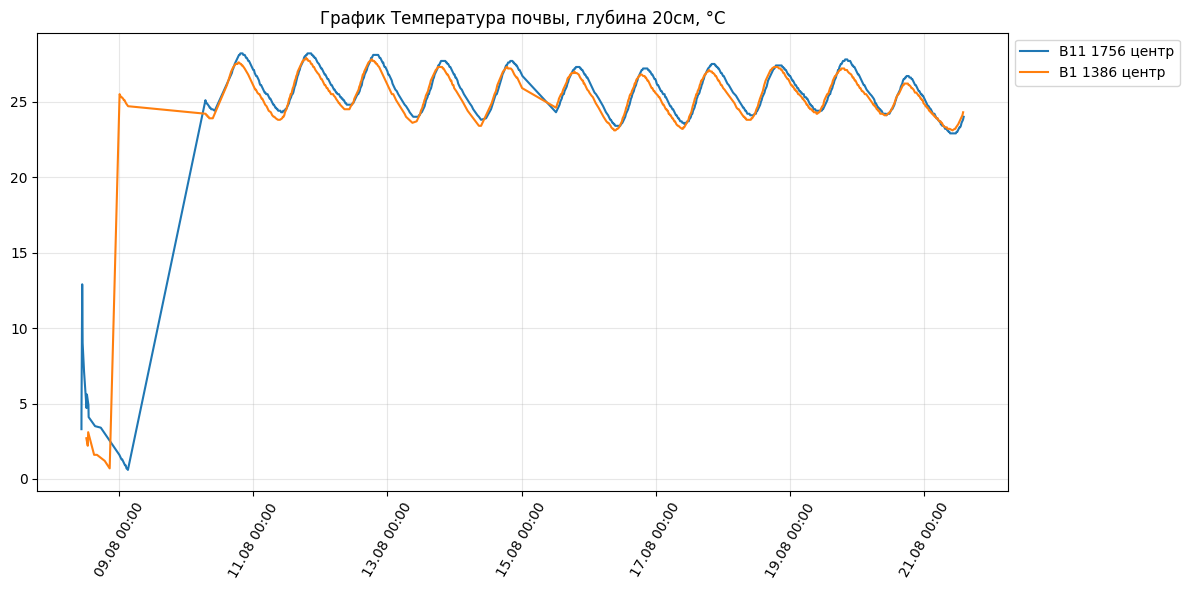

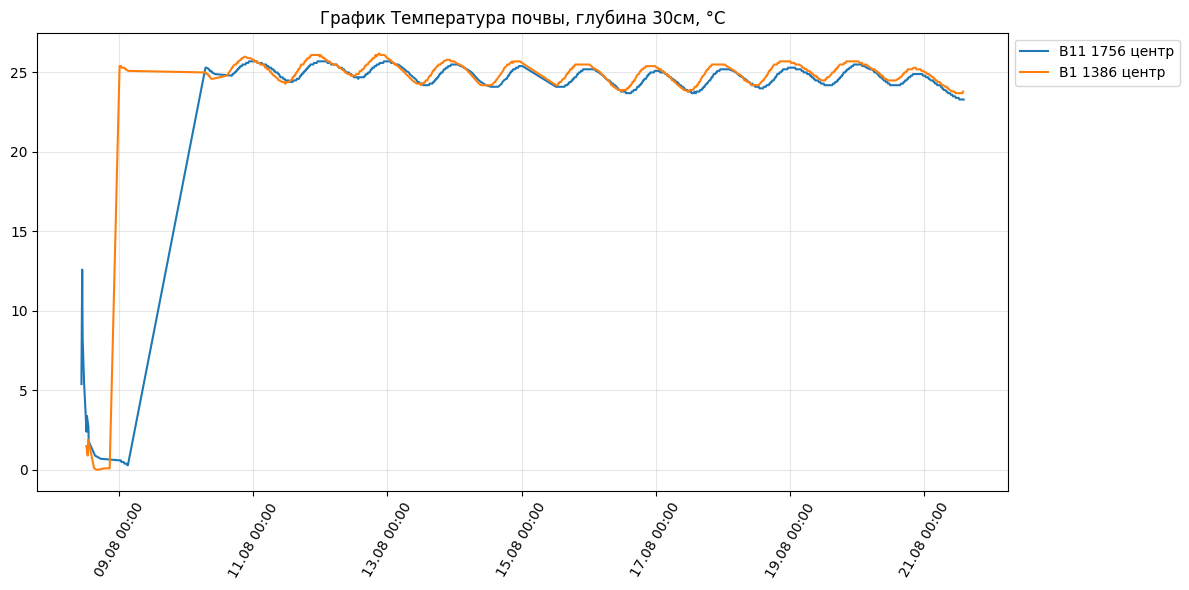

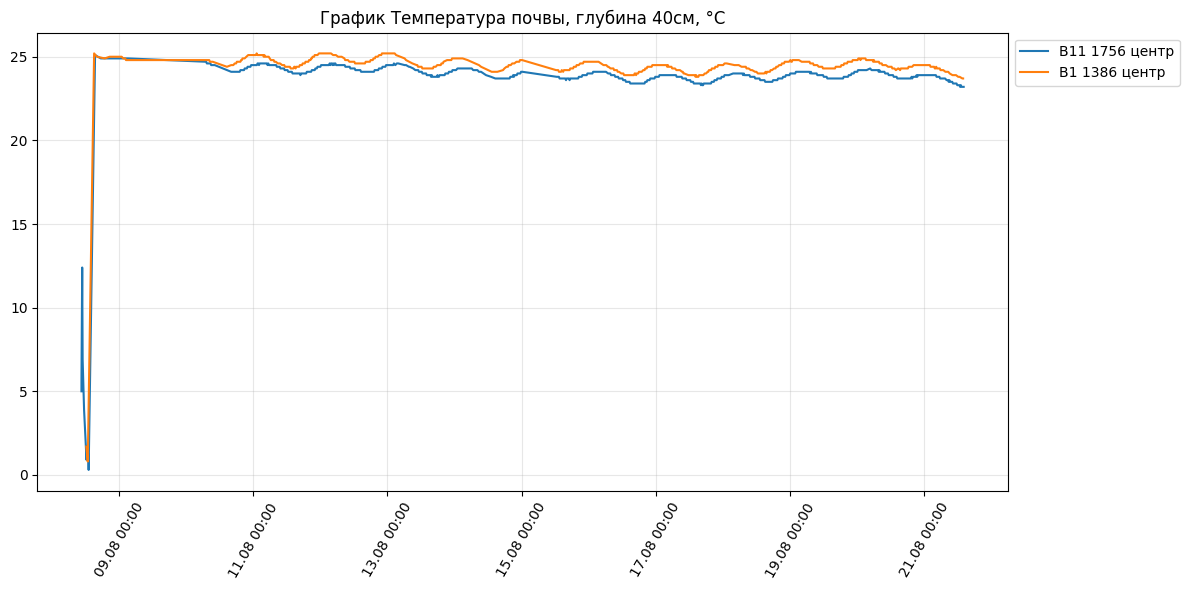

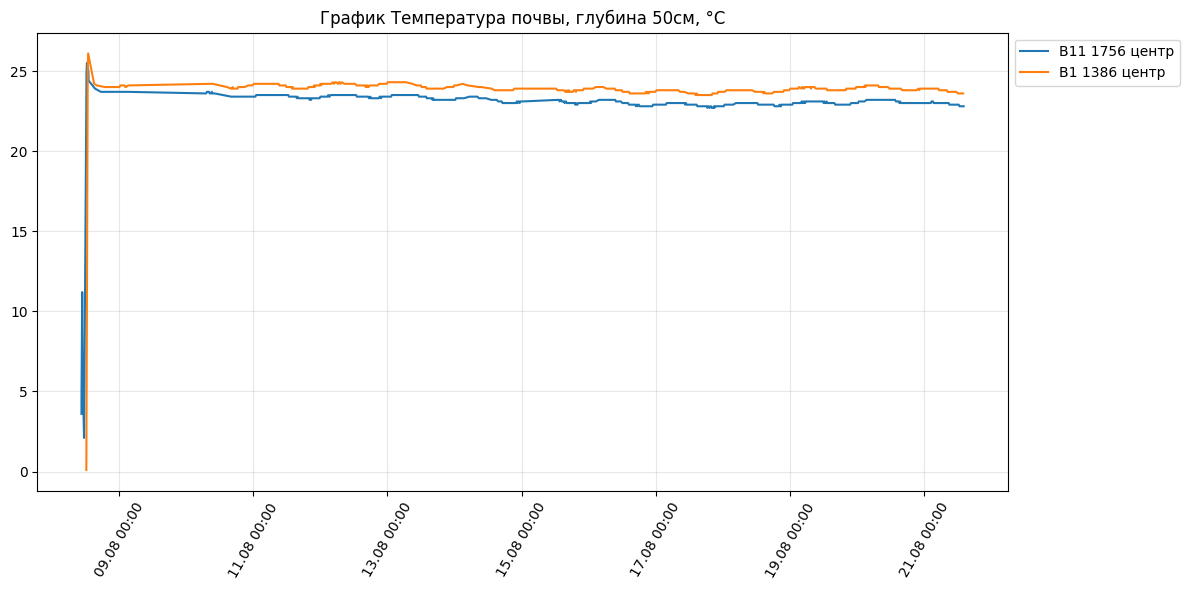

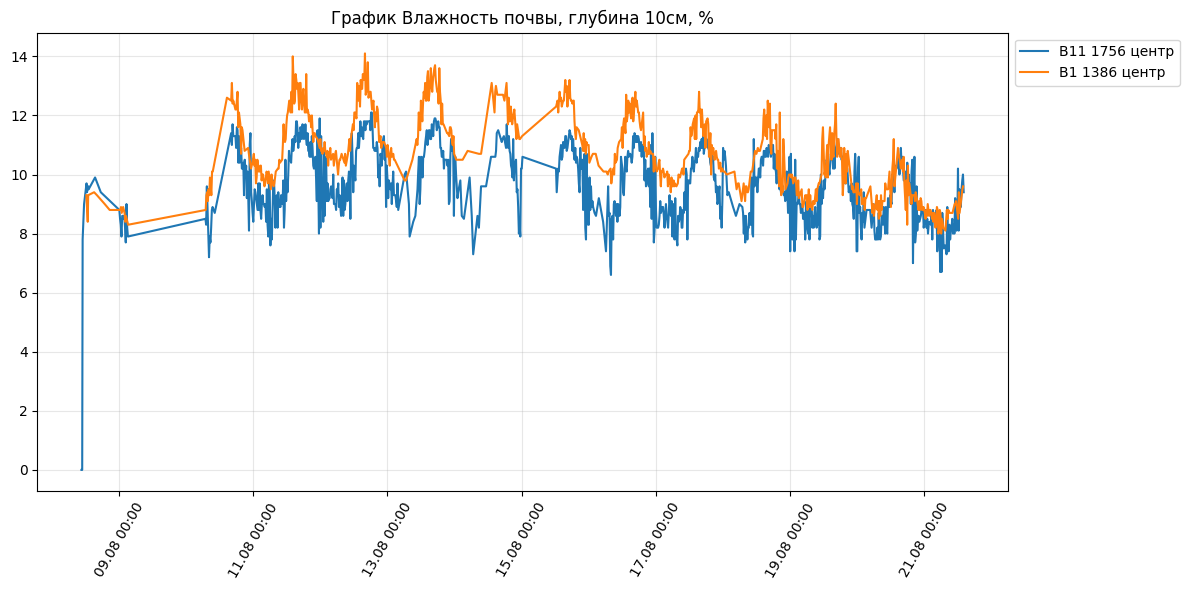

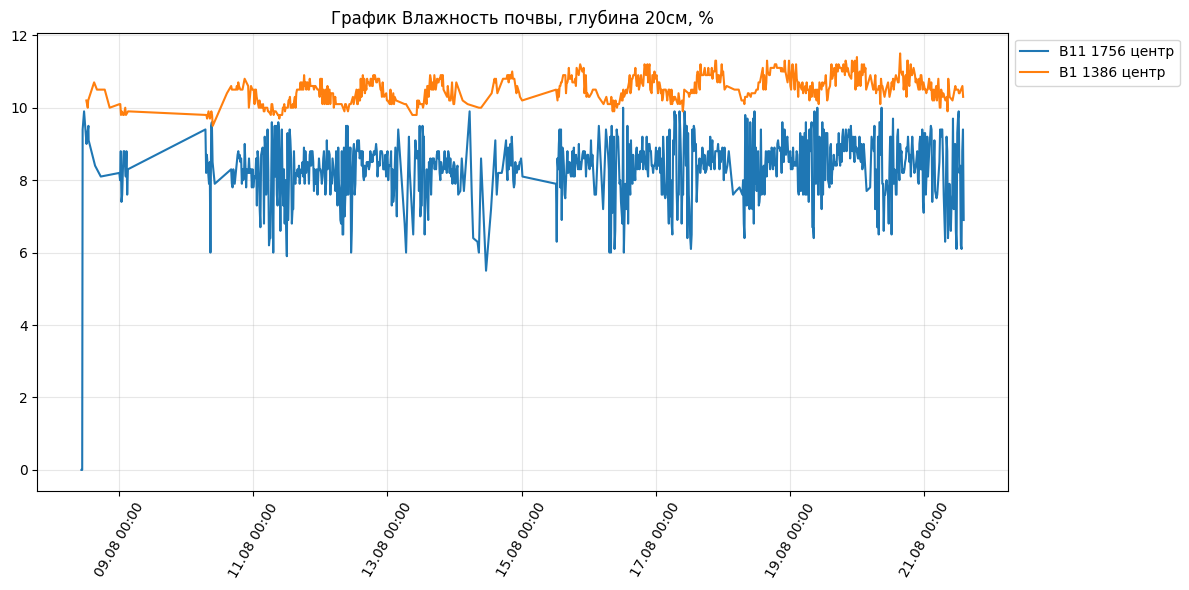

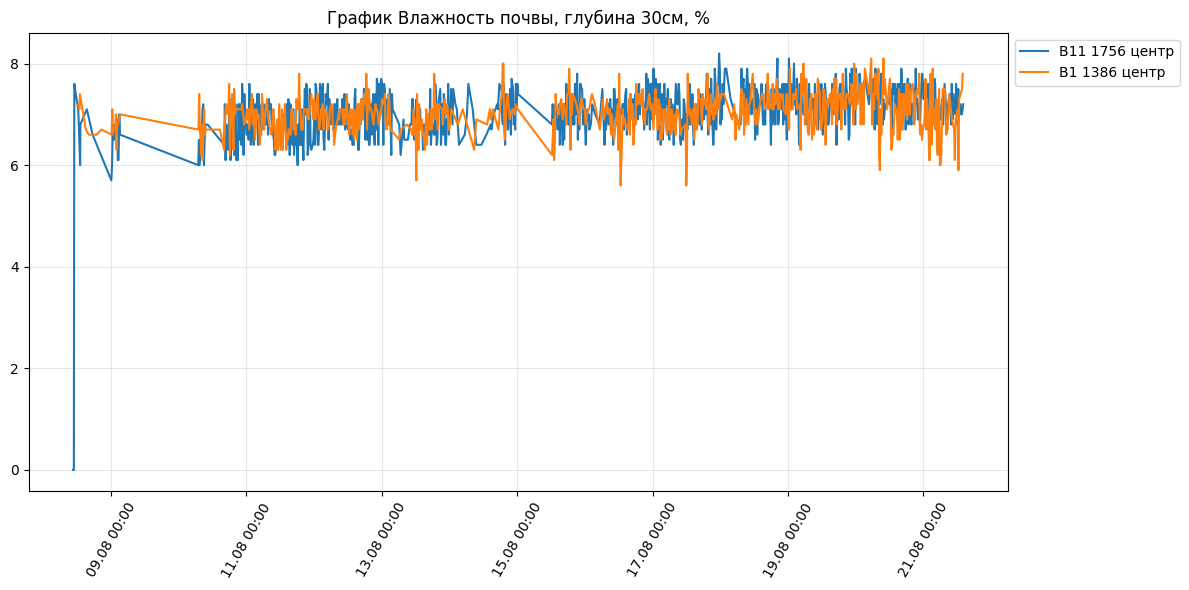

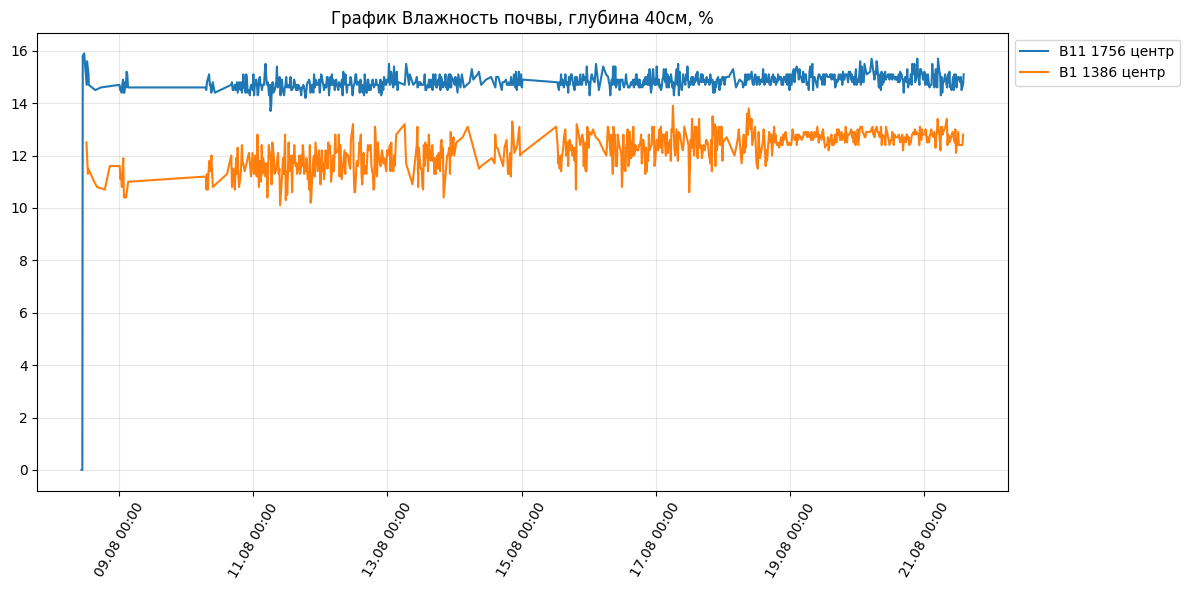

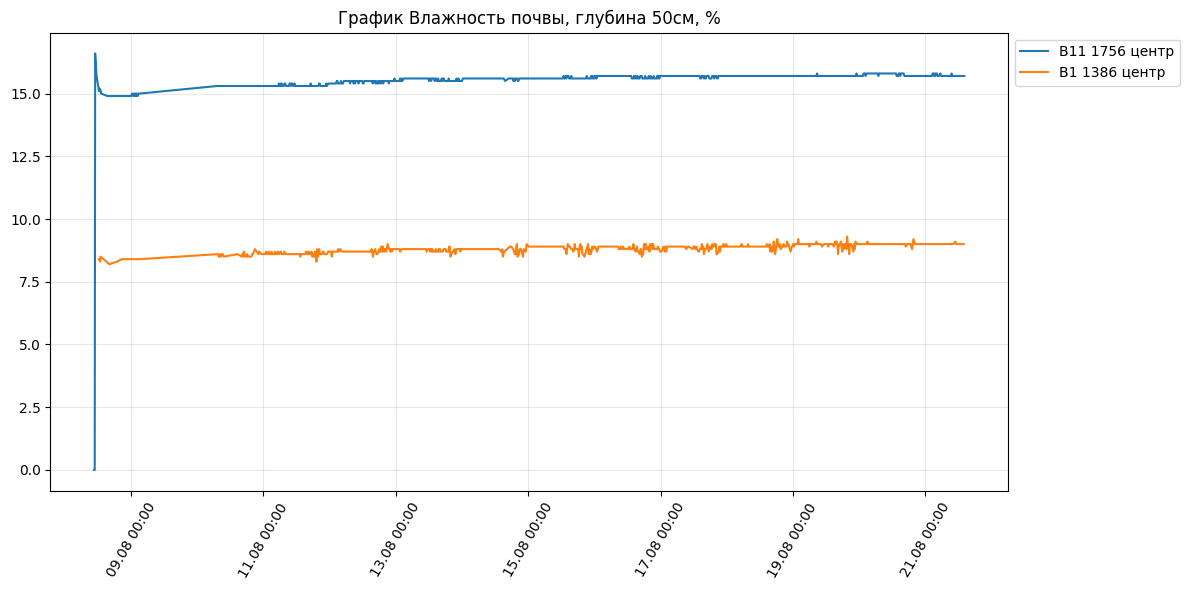

In [ ]:
for p in meteo.columns[4:]:
    plot_graph("meteo", p)


for p in ugv.columns[4:]:
    plot_graph("ugv", p)

In [12]:
def plot_wind_plane(time="all"):
    meteo = pd.read_feather("meteo.feather")

    fig, axs = plt.subplots(1, 3, figsize=(12, 6), subplot_kw={"projection": "polar"})
    curent_time = meteo["datetime"].max()
    if time == "all":
        shift_time = meteo["datetime"].min()
    else:
        if time < 1:
            shift_time = (curent_time - pd.Timedelta(days=time)).replace(
                minute=0, second=0
            )
        else:
            shift_time = (curent_time - pd.Timedelta(days=time)).replace(
                hour=0, minute=0, second=0
            )

    data_time_sort = meteo[
        (meteo["datetime"] <= curent_time) & (meteo["datetime"] >= shift_time)
    ]

    i = 0
    for device_id in ["7", "5", "10"]:
        data = data_time_sort[data_time_sort["id_s"] == device_id]
        d = np.array([0, 0.25, 0.5, 0.75, 1, 1.25, 1.5, 1.75, 0]) * pi

        result = (
            data.groupby("wind_dir")["wind_gust"]
            .mean()
            .reindex(["С", "СВ", "В", "ЮВ", "Ю", "ЮЗ", "З", "СЗ"], fill_value=0.1)
            .to_list()
        )
        result.append(result[0])
        axs[i].plot(d, result, linewidth=1.5, color="r")
        axs[i].fill(d, result, "r", alpha=0.2)

        result = (
            data.groupby("wind_dir")["wind_speed"]
            .mean()
            .reindex(["С", "СВ", "В", "ЮВ", "Ю", "ЮЗ", "З", "СЗ"], fill_value=0.1)
            .to_list()
        )
        result.append(result[0])
        axs[i].plot(d, result, linewidth=1.5, color="b")
        axs[i].fill(d, result, "b", alpha=0.2)

        axs[i].set_theta_direction(-1)
        axs[i].set_theta_offset(pi / 2.0)
        axs[i].set_xticks(d[0:8])
        axs[i].set_xticklabels(["С", "СВ", "В", "ЮВ", "Ю", "ЮЗ", "З", "СЗ"])
        axs[i].set_title(label=sens_dict[device_id])
        i += 1
    legend_elements = [
        Line2D([0], [0], color="b", lw=4, label="Стабильный ветер"),
        Line2D([0], [0], color="r", lw=4, label="Порыв ветра"),
    ]
    fig.legend(handles=legend_elements, loc="lower center", ncol=2)
    fig.suptitle(
        "Роза ветров за период: "
        + str(shift_time.strftime("%H:%M:%S %d.%m.%Y"))
        + "  -  "
        + str(curent_time.strftime("%H:%M:%S %d.%m.%Y"))
    )
    plt.tight_layout()
    plt.savefig("pic.png")
    plt.close()


# plot_wind_plane(24)
plot_wind_plane()

In [13]:
plot_wind_plane(1)

In [14]:
def plot_map(id_s="1", parameter="t", time="all"):
    ugv = pd.read_feather("ugv.feather")
    if parameter == "t":
        parameters = ["t1", "t2", "t3", "t4", "t5"]
        label = "Температура грунта по глубине " + sens_dict[id_s]
        label2 = "Температура, °С"
    if parameter == "h":
        parameters = ["h1", "h2", "h3", "h4", "h5"]
        label = "Влажность грунта по глубине " + sens_dict[id_s]
        label2 = "Влажность, %"

    ylabels = ["50", "40", "30", "20", "10"]
    curent_time = ugv["datetime"].max()
    if time == "all":
        shift_time = ugv["datetime"].min()
    else:
        if time < 1:
            shift_time = (curent_time - pd.Timedelta(days=time)).replace(
                minute=0, second=0
            )
        else:
            shift_time = (curent_time - pd.Timedelta(days=time)).replace(
                hour=0, minute=0, second=0
            )
    data_time_sort = ugv[
        (ugv["datetime"] <= curent_time) & (ugv["datetime"] >= shift_time)
    ]
    data = data_time_sort[data_time_sort["id_s"] == id_s]
    matrix = data[parameters].values.T
    times = data["datetime"].values
    fig, ax = plt.subplots(figsize=(10, 5))
    im = ax.imshow(
        matrix,
        aspect="auto",
        cmap="winter",
        origin="upper",
        extent=[times[0], times[-1], -0.5, len(parameters) - 0.5],  # привязка к времени
        interpolation="gaussian",
    )
    ax.xaxis_date()
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%d.%m %H:%M"))
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=60)
    ax.set_yticks(range(len(parameters)))
    ax.set_ylabel("Глубина, см")
    ax.set_yticklabels(ylabels)
    ax.set_title(label)
    ax.grid()
    fig.colorbar(im, ax=ax, label=label2)
    # plt.savefig('pic.png')
    plt.show()
    plt.close()

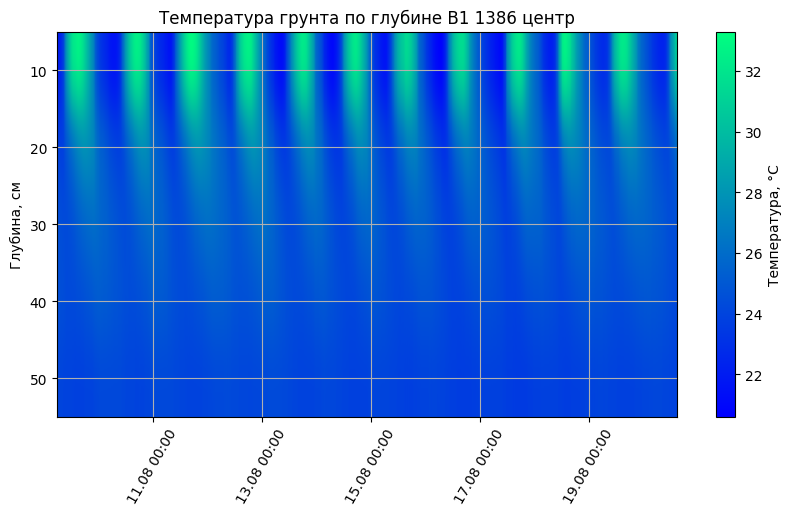

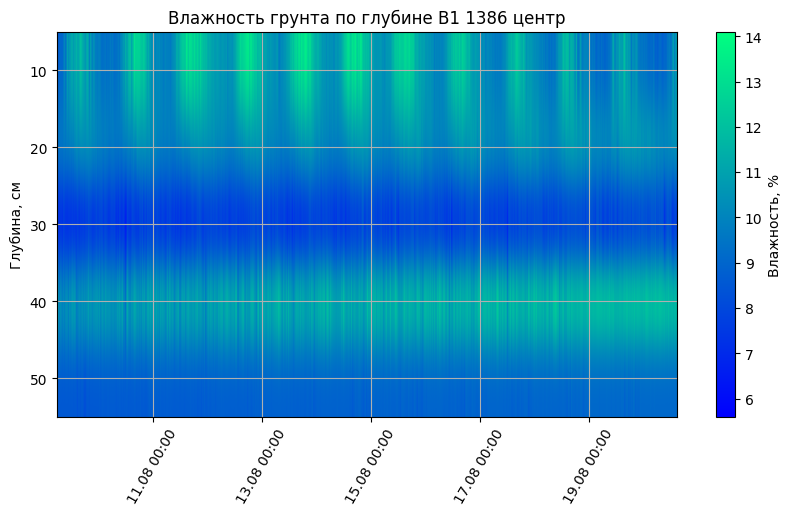

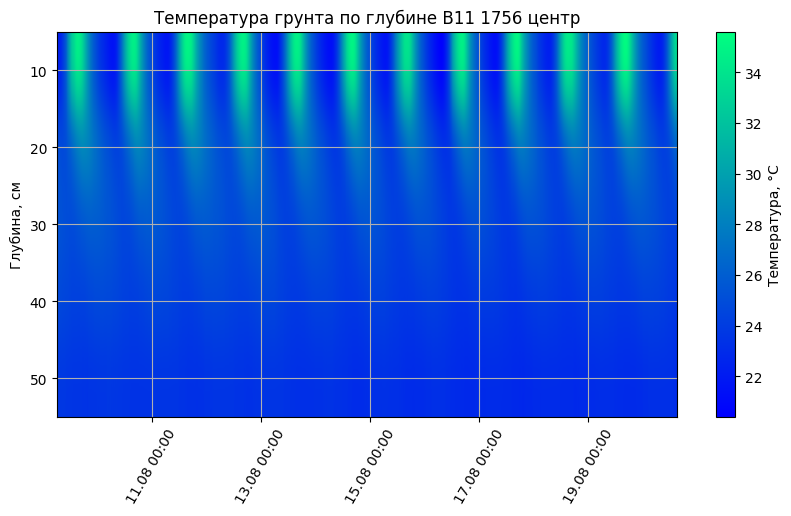

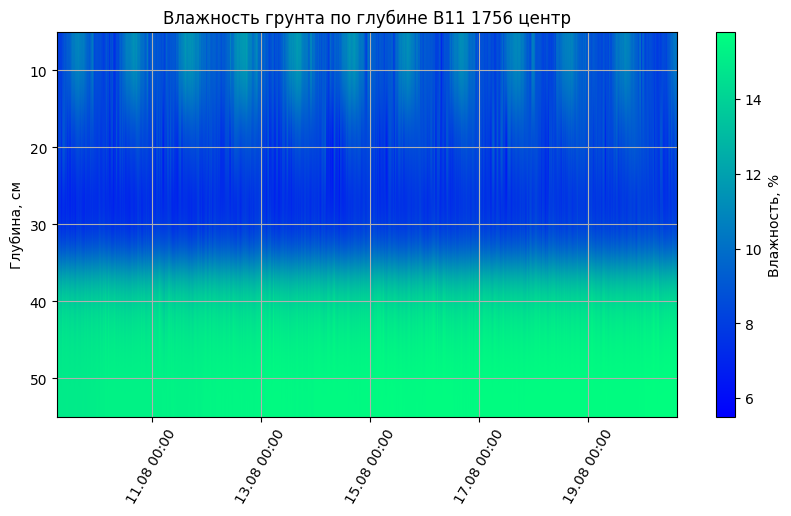

In [15]:
for sens in ["1", "11"]:
    for p in ["t", "h"]:
        plot_map(sens, p)